# <font color=blue>Login Activity Monitor</font>

Author: Hannie Do


**This script has functionality:**

* Real-time Streaming: Emulate a stream by reading one line of the "traffic.csv" file per second.
* Enrichment: Enrich events with AbuseIP, VirusTotal, and WhatismyBrowser data.
* Statistics: Provide a statistical overview of the web traffic in chart.
* Threat Detection: Detect suspicious login activity, generate an actionable alert and trigger an investigation.


**Code Running Instruction:** 
 * All libraries are pip-able
 * You need to have the API keys for [AbuseIP](https://docs.abuseipdb.com/#introduction), [VirusTotal](https://developers.virustotal.com/reference#getting-started), 
[WhatIsMyBrowser](https://developers.whatismybrowser.com/api/) in a text file named config.txt in the same working directory. 
 

### Environment setup: 

In [89]:
import csv
from csv import DictReader
import pandas as pd
import time
import schedule
from pandas import DataFrame
pd.set_option('display.max_colwidth', -1) #without truncated
from collections import Counter
import pprint
pp = pprint.PrettyPrinter(indent=1)
import requests
import json
from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 100em; }</style>"))
from matplotlib import pyplot as plt
from colorama import Fore, Back, Style

#Handle API keys
f = open("config.txt",'r')
keys = f.read()
abuseip_api_key = keys.split(',')[0]
virustotal_api_key = keys.split(',')[1]
whatismybrowser_api_key = keys.split(',')[2]

### Web statistics function: 

Function <font color=blue>traffic_overview (df, code_lst)</font> provides a statistical overview of the web traffic. It takes a dataframe and a list of status codes to generate a simple bar chart showing the frequency of an IP address associated with each request status code. In this case, the data sample has 2 status codes, 200 and 401, representing the Succeeded and Failed logins ==> 2 charts will be generated. 

In [90]:
def traffic_overview(df, code_lst):
    for code in code_lst:
        if code == '401':
            failed = df['ip'].loc[df['status_code']== code]
            failed_ip_frequency = sorted(Counter(pd.Series(failed)).items(), key=lambda kv: kv[1], reverse=True) 
            plt.rcParams['figure.figsize'] = (20,3)
            fig = plt.figure()
            ax = fig.add_axes([0,0,1,1])
            xs = [x[0] for x in failed_ip_frequency]
            ys = [x[1] for x in failed_ip_frequency]
            plt.xlabel('Failed IP')
            plt.ylabel('Frequency')
            plt.title('IP Observed In Failed Requests')
            ax.bar(xs,ys)
        else:
            succeed = df['ip'].loc[df['status_code']== code]
            succeed_ip_frequency = sorted(Counter(pd.Series(succeed)).items(), key=lambda kv: kv[1], reverse=True) 
            plt.rcParams['figure.figsize'] = (20,3)
            fig = plt.figure()
            ax = fig.add_axes([0,0,1,1])
            xs = [x[0] for x in succeed_ip_frequency]
            ys = [x[1] for x in succeed_ip_frequency]
            plt.xlabel('Succeed IP')
            plt.ylabel('Frequency')
            plt.title('IP Observed in Succeeded Requests')
            ax.bar(xs,ys)
            
    return ax.bar(xs,ys)

### Enrichment functions: 

There are 3 enrichment functions in this section: 

* <font color=blue>ip_check_from_abuseip(ip)</font>: function takes an IP address and checks it against the AbuseIp database to see if the IP has ever been abused in any malicious activities in the wild over last 365 days. It prints out the abuse data and the WHOIS record of that IP to help with further investigation. The generated data includes: Abuse Confidence Score, Country Code, Domain, ISP, Usage Type.


* <font color=blue>ip_check_from_virustotal(ip)</font>: function takes an IP address and checks it against the VirusTotal database to see if the IP has ever communicated with any malicious files in the wild. If yes, the generated data includes: SHA256 hashes and the associated condemnations by different security vendors.


* <font color=blue>userAgent_check(userAgent)</font>: function takes a useragent and asks the Whatismybrowser service to translate that useragent into a human-readable format. The generated data includes: the general software and OS the user used to send their login request. This enriched information can be used to define a behavior baseline of a user and identify anomolies in the used devices.

In [91]:
  def ip_check_from_abuseip(ip):
    abuseip_url = 'https://api.abuseipdb.com/api/v2/check'
    abuseip_headers = {
        'Accept': 'application/json',
        'Key': abuseip_api_key
    }
    response = requests.request(method='GET', url=abuseip_url, headers=abuseip_headers, params={
    'ipAddress': ip,
    'maxAgeInDays': '365'})
    decodedResponse = json.loads(response.text)
    abuseConfidenceScore = json.dumps(decodedResponse['data']['abuseConfidenceScore'], sort_keys=True, indent=4)
    countryCode = json.dumps(decodedResponse['data']['countryCode'], sort_keys=True, indent=4)
    domain = json.dumps(decodedResponse['data']['domain'], sort_keys=True, indent=4)
    isp = json.dumps(decodedResponse['data']['isp'], sort_keys=True, indent=4)
    usageType = json.dumps(decodedResponse['data']['usageType'], sort_keys=True, indent=4)
    print(f"Abuse Confidence Score: {abuseConfidenceScore}\n"
          f"Country Code: {countryCode}\n"
          f"Domain: {domain}\n"
          f"ISP: {isp}\n"
          f"Usage Type: {usageType}\n")
    
        
def ip_check_from_virustotal(ip):
    virustotal_base_url = 'https://www.virustotal.com/api/v3/ip_addresses/'
    virustotal_header = {'x-apikey': virustotal_api_key}
    url = virustotal_base_url + ip + '/communicating_files'
    response = requests.request(method='GET', url=url, headers=virustotal_header)
    decodedResponse = json.loads(response.text)
    file_count = decodedResponse['meta']['count']
    if file_count != 0: 
        print(f"\nThe IP has communicated with {file_count} evil files listed below")
        vendor_list = list(decodedResponse['data'][0]['attributes']['last_analysis_results'].keys())
        for i in range(0,len(decodedResponse['data'])):
            print (f"\n======\n\nSHA256: {decodedResponse['data'][i]['attributes']['sha256']}")
            print (f"\nDetected as:\n")   
            for vendor in vendor_list:
                if vendor in (decodedResponse['data'][i]['attributes']['last_analysis_results']):
                    detection_status = decodedResponse['data'][i]['attributes']['last_analysis_results'][str(vendor)]['category']
                    if detection_status != 'undetected':
                        result = (decodedResponse['data'][i]['attributes']['last_analysis_results'][str(vendor)]['result'])
                        if result != None:
                            print(result)
                   
                   
def userAgent_check(userAgent):
    whatismybrowser_url = 'https://api.whatismybrowser.com/api/v2/user_agent_parse'
    headers = {
        'X-API-KEY': whatismybrowser_api_key}
    post_data = {"user_agent": userAgent}
    response = requests.post(whatismybrowser_url, data=json.dumps(post_data), headers=headers)
    decodedResponse = json.loads(response.text)
    print(f'UserAgent: {userAgent}\n')
    pp.pprint(decodedResponse['parse'])
                   


### Threat detection 

Function <font color=blue>suspicious_login(df)</font> takes a dataframe and detects the suspicious users that have more than 2 failed logins. Once detected, the function prints the userid out, generates an actionable alert, and triggers the IP + useragent checks to quickly investigate the incident (which could be a password stuffing/brute-forcing attack, account takeover, or a bot account etc.)

In [92]:
def suspicious_login(df):
    failed_login = df.loc[df['status_code'] == '401']
    success_login = df.loc[df['status_code'] == '200']
    #Filter userid that has more than 2 failed login
    userid_frequency = sorted(Counter(pd.Series(failed_login['userid'])).items(), key=lambda kv: kv[1], reverse=True) 
    failed_userid_lst = []
    for i in range (0, len(userid_frequency)):  
        failed_userid = userid_frequency[i][0]
        failed_cnt = userid_frequency[i][1]
        if failed_cnt > 2:
            failed_userid_lst.append(failed_userid)
    print(Fore.GREEN + Style.BRIGHT + f"{len(failed_userid_lst)} SUSPICIOUS USER DETECTED: {failed_userid_lst}\n")
    for failed_userid in failed_userid_lst:
        userid_failed_login = failed_login.loc[failed_login['userid'] == failed_userid]
        userid_failed_ip_lst = list(set(list(userid_failed_login['ip'])))
        userid_failed_userAgent_lst = list(set(list(userid_failed_login['useragent'])))
        userid_success_login = success_login.loc[success_login['userid'] == failed_userid]
        userid_success_ip_lst = list(set(list(userid_success_login['ip'])))
        userid_success_userAgent_lst = list(set(list(userid_success_login['useragent'])))
        print(Fore.BLACK + f"User {failed_userid} has {len(userid_failed_login)} failed logins and {len(userid_success_login)} success logins. Looked like he/she took over the account!\n"
              f"Triggering some checks now!\n\n"
              f"Total {len(userid_failed_ip_lst)} IP addresses and {len(userid_failed_userAgent_lst)} UserAgents observed in the failed logins.\n"
              f"Total {len(userid_success_ip_lst)} IP addresses and {len(userid_success_userAgent_lst)} UserAgents observed in the succeeded login.\n")
        for ip in userid_failed_ip_lst:
            print(Fore.RED + f"\n***{ip}-failed***\n")
            ip_check_from_abuseip(ip)   
            ip_check_from_virustotal(ip)
        for ip in userid_success_ip_lst:
            print(Fore.BLUE + f"\n***{ip}-succeeded***\n")
            ip_check_from_abuseip(ip)   
            ip_check_from_virustotal(ip)
        for userAgent in userid_failed_userAgent_lst:
            print(Fore.RED + f"\n***{userAgent}***\n")
            userAgent_check(userAgent)
        for userAgent in userid_success_userAgent_lst:
            print(Fore.BLUE + f"\n***{userAgent}-succeeded***\n")
            userAgent_check(userAgent)

### Real-time data streaming and put them all together

The script below runs as follow:

* Reads data from the sample data file, "traffic.csv", 1 line per second. 
* Presents web statistics in chart. Please note that I have not figured out a way to do this step every 15 seconds as required. So, the chart here represents for the whole sample dataset.
* Detects suspicious logins and triggers an investigation

Streaming data in 1 line per second...



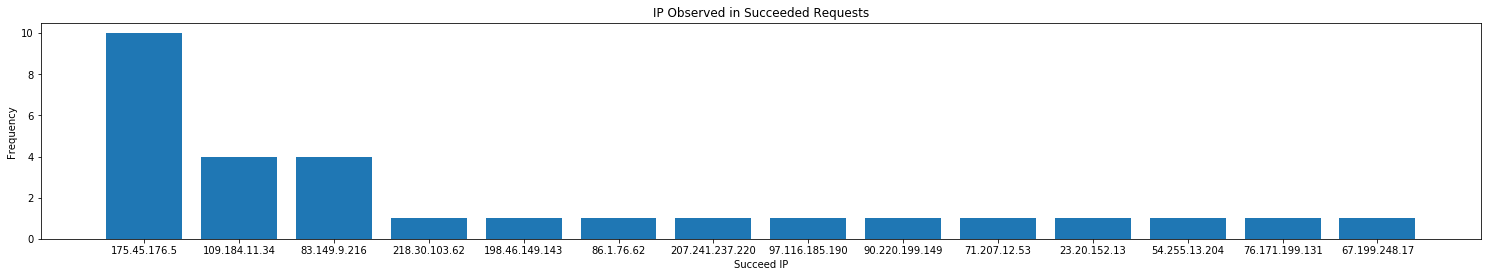

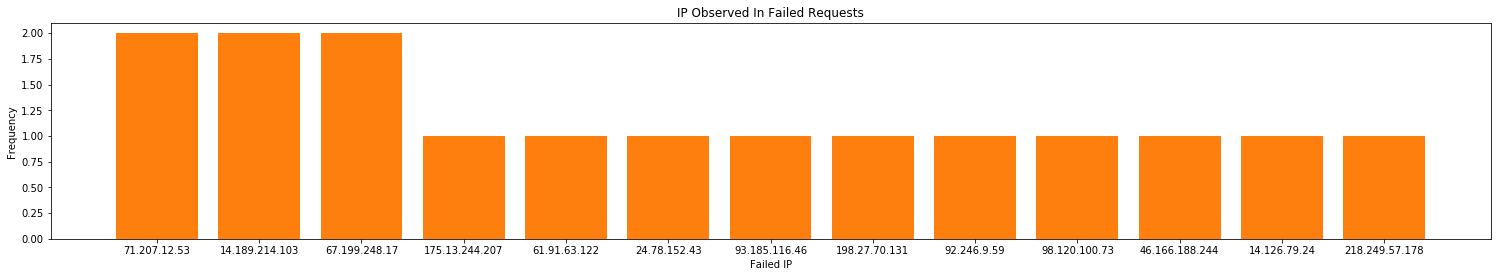

In [93]:
#Streaming data 1 line per second
with open('traffic.csv', 'r') as read_obj:
    csv_reader = DictReader(read_obj)
    df_master = DataFrame(columns = ['userid','event_type','status_code','ip', 'useragent'])
    print(f'Streaming data in 1 line per second...\n') 
    for row in csv_reader:
        time.sleep(1)
        #Put data into a dataframe for further analysis
        df = pd.DataFrame([row]) 
        df_master = df_master.append(df)
        df_master = df_master.reset_index(drop=True)
    code_lst = list(set(df_master['status_code']))
    traffic_overview(df=df_master, code_lst=code_lst)


In [94]:
suspicious_login(df_master)

1 SUSPICIOUS USER DETECTED: ['henry']

User henry has 12 failed logins and 1 success logins. Looked like he/she took over the account!
Triggering some checks now!

Total 11 IP addresses and 2 UserAgents observed in the failed logins.
Total 1 IP addresses and 1 UserAgents observed in the succeeded login.


***61.91.63.122-failed***

Abuse Confidence Score: 0
Country Code: "TH"
Domain: "trueinternet.co.th"
ISP: "True Internet Corporation Co. Ltd."
Usage Type: "Fixed Line ISP"


***175.13.244.207-failed***

Abuse Confidence Score: 0
Country Code: "CN"
Domain: "chinatelecom.com.cn"
ISP: "ChinaNet Hunan Province Network"
Usage Type: null


***24.78.152.43-failed***

Abuse Confidence Score: 0
Country Code: "CA"
Domain: "shawcable.net"
ISP: "Shaw Communications Inc."
Usage Type: "Fixed Line ISP"


***14.126.79.24-failed***

Abuse Confidence Score: 0
Country Code: "CN"
Domain: "chinatelecom.com.cn"
ISP: "ChinaNet Guangdong Province Network"
Usage Type: null


***46.166.188.244-failed***

Abuse

### Future Improvements:

1. When streaming data 1 line per second, we need a database (for ex: MySQL) to write data in and allow the web statistic function <font color=blue>traffic_overview</font> to query the data every 15 seconds to update the charts.


2. Regarding the threat detection, we can write another function to identify strange behavior in the succeeded login aspect. For example, looking at the blue chart above, the IP 175.45.176.5 has sent 10 login requests within only 45 seconds. All succeded. It could be indicative of a bot account and needs to dig deeper into.


3. Regarding the Whatismybrowser service used for the <font color=blue>userAgent_check</font> function, note that as I used my free API tier, the information is limited to software and OS. With premium API, however, Whatismybrowser service can provide granular information, such as hardware (phone/tablet/pc/etc), software_subtype (browser/application/bot), software_sub_subtype (crawler/analyser/tool/security-analyser/site-monitor/feed-fetcher). These details can become very valuable in investgating a bot account or tracing threat actor's infrastructure and behavior patterns used to launch the attack.